In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import load_W
import tensorflow as tf

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

In [23]:
D = 4
lb = 0.*np.ones((D,))
ub = 20.*np.ones((D,))

sigma_eps = Parameter("sigma_eps", D, lb=lb, ub=ub)
parameters = [sigma_eps]

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [24]:
# Define model
name = "SSSN"
model = Model(name, parameters)

In [25]:
npzfile = np.load('SV_mode.npz')
z_mode1 = npzfile['z_mode1'][0]
DH = z_mode1[4]
H = z_mode1[:4] + DH*np.array([1., 1., 0., 0.])
print(H)

[15.58675528 25.77151394  6.27221107 11.68144608]


In [26]:
# Dim is [M,N,|r|,T]
def euler_sim_stoch(f, x_init, dt, T):
    x = x_init
    for t in range(T):
        x = x + f(x) * dt
    return x[:, :, :, 0]

def euler_sim_stoch_traj(f, x_init, dt, T):
    x = x_init
    xs = [x_init]
    for t in range(T):
        x = x + f(x) * dt
        xs.append(x)
    return tf.concat(xs, axis=3)

In [27]:
import tensorflow as tf

V_INIT = tf.constant(-65.*np.ones((1,4,1)), dtype=np.float32)

k = 0.3
n = 2.
v_rest = -70.

dt = 0.005

N = 20
T = 100

def f_r(v):
    return k*(tf.nn.relu(v-v_rest)**n)

def SSSN_sim(sigma_eps):
    h = H[None,None,:,None]

    W = load_W()
    #sigma_eps = 0.2*np.array([1., 0.5, 0.5, 0.5])
    tau = np.array([0.02, 0.01, 0.01, 0.01])
    tau_noise = np.array([0.05, 0.05, 0.05, 0.05])

    W = W[None,:,:,:]
    sigma_eps = sigma_eps[:,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]

    _v_shape = tf.ones((sigma_eps.shape[0], N, 4, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)

    def f(y):
        v = y[:,:,:4,:]
        eps = y[:,:,4:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))

        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise

        return tf.concat((dv, deps), axis=2)

    v_ss = euler_sim_stoch(f, y_init, dt, T)
    return v_ss

In [28]:
def dr(sigma_eps):
    x1 = f_r(SSSN_sim(0.*sigma_eps)[:,:,:4])
    x2 = f_r(SSSN_sim(sigma_eps)[:,:,:4])

    diff = tf.reduce_mean(x2 - x1, axis=1)
    T_x = tf.concat((diff, diff ** 2), axis=1)

    return T_x

In [29]:
purple = '#4C0099'
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"

def plot_T_x(T_x, T_x_sim, bins=30, xmin=None, xmax=None, xlabel=None, ylim=None, fontsize=14):
    if xmin is not None and xmax is not None:
        _range = (xmin, xmax)
    else:
        _range = None
    plt.figure()
    if T_x is None:
        plt.hist(T_x_sim, bins=bins, range=_range, color=purple, alpha=0.5)
    else:
        n, bins, patches = plt.hist(T_x, bins=bins, color='k', range=_range, alpha=0.5)
        plt.hist(T_x_sim, bins=bins, color=purple, alpha=0.5)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel('count', fontsize=fontsize)
    return None

E: 2 623/500
P: 4 567/500
S: 8 528/500
V: 4 532/500


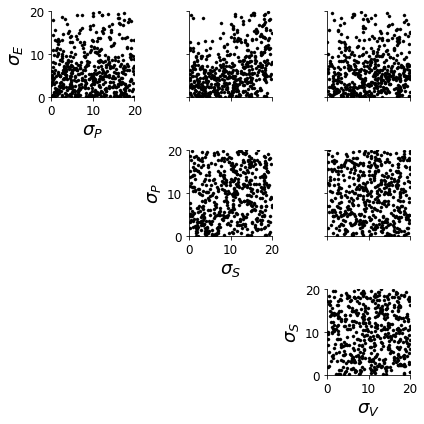

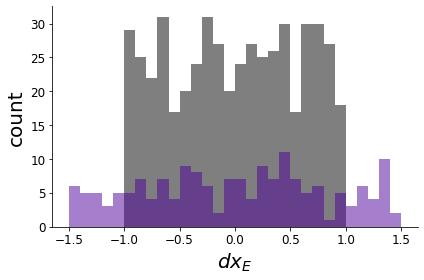

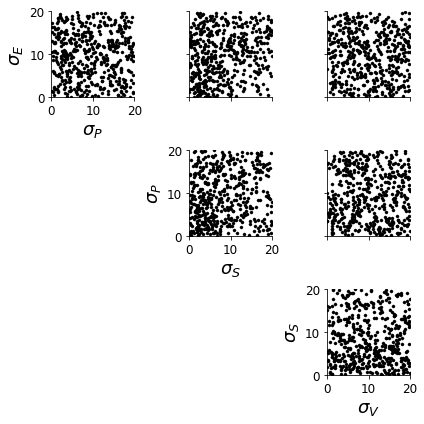

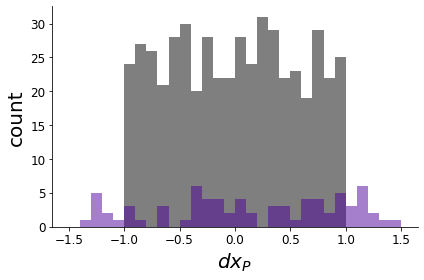

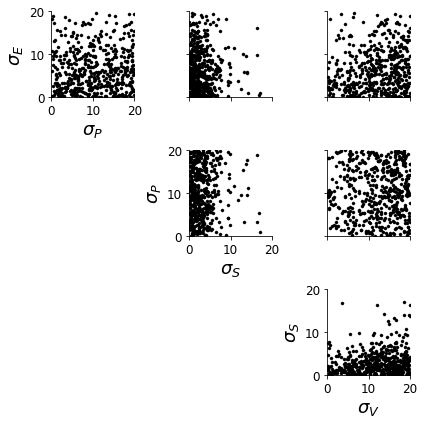

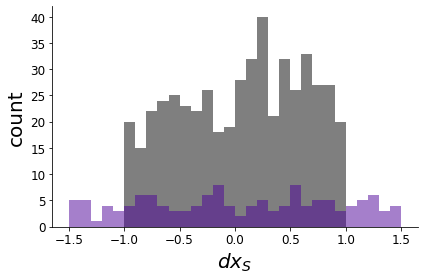

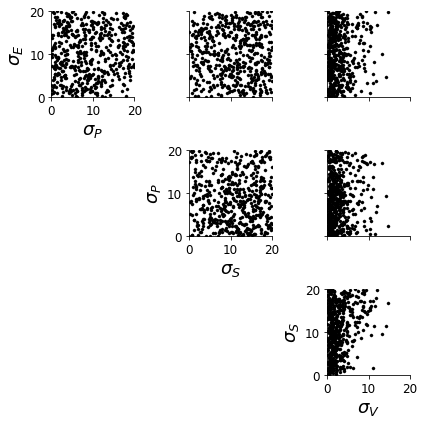

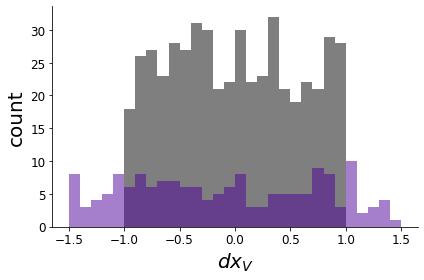

In [30]:
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, alpha, inc_std):
    neuron_ind = neuron_inds[alpha]
    return np.logical_and(-2*inc_std < T_x[:,neuron_ind], 
                          T_x[:,neuron_ind] < 2*inc_std)


alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)
num_keep = int(5e2)
num_plot = int(5e2)
M = 2000
zs = []
T_xs = []

inc_std = .5
sigma_epss = [1.]


for sigma_eps in sigma_epss:
    dr_all = dr
    model.set_eps(dr_all)
    zs_i = []
    T_xs_i = []
    for i in range(num_alphas):
        alpha = alphas[i]
        name = "V1_Circuit_%s_eps=%.2f" % (alpha, sigma_eps)
        #M = Ms[k][i]
        neuron_ind = neuron_inds[alpha]
        fontsize = 30

        num_found = 0
        z = None
        T_x = None
        count = 0
        while (num_found < num_keep):
            count += 1
            _z = np.zeros((M, D))
            for j in range(D):
                _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
            _T_x = model.eps(_z).numpy()

            inds = accept_inds(_T_x, alpha, inc_std)
            _z = _z[inds, :]
            _T_x = _T_x[inds, :]
            num_found += _z.shape[0]
            
            if (z is None):
                z = _z
                T_x = _T_x
            else:
                z = np.concatenate((z, _z), axis=0)
                T_x = np.concatenate((T_x, _T_x), axis=0)
            print('%s: %d %d/%d\r' % (alpha, count, num_found, num_keep), end='')

        num_found = z.shape[0]
        
        # reduce to num_keep
        z = z[:num_keep]
        T_x = T_x[:num_keep]
        zs_i.append(z)
        T_xs_i.append(T_x)

        negd = -np.square(T_x[:,neuron_ind])
        z_labels = [r'$\sigma_E$', r'$\sigma_P$', r'$\sigma_S$', r'$\sigma_V$']
        fig = pairplot(z[:num_plot], np.arange(4), z_labels, figsize=(6,6),
                       fontsize=18, lb=lb, ub=ub)
        plt.tight_layout()
        plt.savefig(figdir + name + '_ABC_z.png')
        
        T_x_sim = model.eps(z).numpy()
        
        plot_T_x(T_x[:,neuron_ind], T_x_sim[:,neuron_ind], xmin=-3*inc_std, xmax=3.*inc_std, xlabel=r'$dx_%s$' % alpha, fontsize=20)
        plt.tight_layout()
        plt.savefig(figdir + name + '_ABC_Tx.png')
        print('')
        
    
    zs.append(zs_i)
    T_xs.append(T_xs_i)